# Setup

## Colab

In [1]:
# Mount the drive and move to dir
from google.colab import drive
drive.mount("/content/drive", force_remount = False)
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import BertGridNew

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertGridNew)

# Import the model and funcs required from utils
# from classes.models.BertGridNew import BertGridNew
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [3]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# Setup the config
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertGrid",
    "model_base": "bert-base-cased",
    "data_ds": "manual",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    "gradient_checkpointing": False,
    # Training Parameters
    "batch_size": 12,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 100,
    "patience": 2,
    "save_int": 0,
}

# input_config = {
#     # Environment and Model Info
#     "env": "local",
#     "approach": "bert",
#     "model_name": "BertGrid",
#     "model_base": "bert-base-cased",
#     "data_ds": "manual",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 32,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 128,
#     "gradient_checkpointing": False,
#     # Training Parameters
#     "batch_size": 4,
#     "lr": 1e-2,
#     "mu": 0.25,
#     "epochs": 10,
#     "patience": 2,
#     "save_int": 0,
# }
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 4413.20it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 6119.50it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertGrid",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 12,
  "lr": 0.001,
  "mu": 0.25,
  "epochs": 100,
  "patienc

# NEW TESTER

## Model Creation -> Single Example Check

In [4]:
# Imports
import math

import torch
import torch.nn as nn
from transformers import BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertGrid class
class BertGrid(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
    config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Disable efficient sdp causes problem
        torch.backends.cuda.enable_mem_efficient_sdp(False)

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Initialize both the BERT model and the enriched encoder using the same config.
        self.bertModel_cell = BertModel(self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute both versions of positional encodings
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    # Function to get positional encodings for cells
    def get_posEncoding(self, num_rows=100, num_cols=100):
      """Generates positional encodings for grid cells using sinusoidal functions.

      Args:
          num_rows (int, optional): Number of rows. Defaults to 100
          num_cols (int, optional): Number of columns. Defaults to 100

      Returns:
          torch.Tensor: Tensor of shape [1, rows*cols, hidden_size] containing combined
                      positional encodings for each grid position
      """
      # Initialize the positional encoding matrix [max_dim, hidden_size]
      max_dim = max(num_rows, num_cols)
      posEncoding = torch.zeros(max_dim, self.hidden_size, device=self.device)

      # Create position vector and frequency terms
      pos = torch.arange(max_dim, dtype=torch.float, device=self.device).unsqueeze(1)
      div_term = torch.exp(
          torch.arange(0, self.hidden_size, 2, dtype=torch.float, device=self.device)
          * (-math.log(10000.0) / self.hidden_size)
      )

      # Apply sin to even indices and cos to odd indices
      posEncoding[:, 0::2] = torch.sin(pos * div_term)
      posEncoding[:, 1::2] = torch.cos(pos * div_term)

      # Get indices for all grid positions
      positions = torch.arange(num_rows * num_cols, device=self.device)
      row_indices = positions // num_cols
      col_indices = positions % num_cols

      # Return combined row and column encodings [1, rows*cols, hidden_size]
      return (posEncoding[row_indices] + posEncoding[col_indices]).unsqueeze(0)


    # New fully optimized forward function
    def forward(self, input_ids, attention_mask):
        """Processes input through the model with fully vectorized operations."""
        batch_size, rows, cols, seq_len = input_ids.shape

        # Return the S_cube directly using pre-computed pos_encodings
        return (
            self.binary_classifier(
                self.bertEncoder_spatial(
                    (
                        self.bertModel_cell(
                            input_ids=input_ids.reshape(-1, seq_len),
                            attention_mask=attention_mask.reshape(-1, seq_len),
                        ).pooler_output.reshape(batch_size, rows * cols, self.hidden_size)
                    ) + self.pos_encodings.expand(batch_size, -1, -1)
                )[0]
            )
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

In [6]:
# import importlib
# import time

# from utils import selfutil

# importlib.reload(selfutil)

# from utils.selfutil import compare_sCube, oneBatch_check

# ex_file, ex_xtok, ex_xmasks, ex_ytok = oneBatch_check(
#     batch_size=20, data_loader=train_loader, device=DEVICE
# )

# untrained_model = BertGrid(config).to(DEVICE)
# untrained_model.eval()

# with torch.no_grad():
#     start_time_forward2 = time.time()
#     out2 = untrained_model.forward2(ex_xtok, ex_xmasks)
#     elapsed_forward2 = time.time() - start_time_forward2
#     print(f"NEW forward2: {elapsed_forward2:.3f} seconds")

#     start_time_forward = time.time()
#     out = untrained_model.forward(ex_xtok, ex_xmasks)
#     elapsed_forward = time.time() - start_time_forward
#     print(f"OLD forward: {elapsed_forward:.3f} seconds")

# compare_sCube(out, out2, ex_file, tolerance=1e-6)

Filenames:	['../data/manual_train/dlportfoliobydelinquencystatus.xls', '../data/manual_train/dlbydefermenttype.xls', '../data/manual_train/dlportfolio-by-debt-size.xls', '../data/manual_train/dlbydefermenttype copy.xls', '../data/manual_train/dlbyforbearancetype copy.xls', '../data/manual_train/portfoliobyloanstatus copy.xls', '../data/manual_train/portfoliobyloanstatus.xls', '../data/manual_train/dlportfolio-by-debt-size copy.xls', '../data/manual_train/idrportfolio-by-debt-size.xls', '../data/manual_train/dlportfoliobydelinquencystatus copy.xls', '../data/manual_train/portfolio-by-school-type.xls', '../data/manual_train/idrportfolio-by-school-type.xls', '../data/manual_train/idrportfolio-by-school-type copy.xls', '../data/manual_train/Harassment-Bullying-on-basis-of-race_reported.xlsx', '../data/manual_train/Harassment-Bullying-on-basis-of-race_reported copy.xlsx', '../data/manual_train/harassment-bullying-on-basis-of-sex-reported.xlsx', '../data/manual_train/portfoliobyloantype copy

The outputs are identical.


# Model Training

In [5]:
# Create and observe the model
untrained_model = BertGrid(config).to(DEVICE)
print(untrained_model)

BertGrid(
  (bertModel_cell): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
   

## Training Metrics

1. GPU Model: 517 mb
2. GPU Training: 36.7 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [6]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    # isPerp=True,
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Train Loss: 1.4060e+00, Val Loss: 1.2568e+00


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.2497e+00, Val Loss: 1.1689e+00


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 1.1725e+00, Val Loss: 1.1091e+00


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.1347e+00, Val Loss: 1.0618e+00


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Train Loss: 1.0765e+00, Val Loss: 1.0166e+00


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 1.0391e+00, Val Loss: 9.7543e-01


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.0030e+00, Val Loss: 9.3542e-01


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 9.7379e-01, Val Loss: 8.9742e-01


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 9.2197e-01, Val Loss: 8.5594e-01


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Train Loss: 8.9281e-01, Val Loss: 8.1329e-01


Epoch 10


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 8.2786e-01, Val Loss: 7.6775e-01


Epoch 11


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Train Loss: 8.0366e-01, Val Loss: 7.2290e-01


Epoch 12


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 7.5793e-01, Val Loss: 6.7685e-01


Epoch 13


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 7.1047e-01, Val Loss: 6.3220e-01


Epoch 14


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 6.7583e-01, Val Loss: 5.9267e-01


Epoch 15


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 6.3361e-01, Val Loss: 5.5612e-01


Epoch 16


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 6.0015e-01, Val Loss: 5.2314e-01


Epoch 17


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 5.7541e-01, Val Loss: 4.9536e-01


Epoch 18


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 5.2818e-01, Val Loss: 4.6957e-01


Epoch 19


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Train Loss: 5.1342e-01, Val Loss: 4.4822e-01


Epoch 20


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 4.9921e-01, Val Loss: 4.2925e-01


Epoch 21


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 4.7414e-01, Val Loss: 4.1183e-01


Epoch 22


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 4.6475e-01, Val Loss: 3.9647e-01


Epoch 23


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 4.3609e-01, Val Loss: 3.8120e-01


Epoch 24


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 4.2891e-01, Val Loss: 3.6825e-01


Epoch 25


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 4.2616e-01, Val Loss: 3.5727e-01


Epoch 26


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 4.0783e-01, Val Loss: 3.4542e-01


Epoch 27


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Train Loss: 4.0480e-01, Val Loss: 3.3467e-01


Epoch 28


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 3.7339e-01, Val Loss: 3.2411e-01


Epoch 29


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 3.7193e-01, Val Loss: 3.1530e-01


Epoch 30


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 3.6067e-01, Val Loss: 3.0670e-01


Epoch 31


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Train Loss: 3.4224e-01, Val Loss: 2.9769e-01


Epoch 32


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Train Loss: 3.3712e-01, Val Loss: 2.9050e-01


Epoch 33


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 3.4080e-01, Val Loss: 2.8483e-01


Epoch 34


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 3.2655e-01, Val Loss: 2.7751e-01


Epoch 35


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Train Loss: 3.1116e-01, Val Loss: 2.7162e-01


Epoch 36


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 3.0436e-01, Val Loss: 2.6598e-01


Epoch 37


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.9942e-01, Val Loss: 2.6089e-01


Epoch 38


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 3.0006e-01, Val Loss: 2.5625e-01


Epoch 39


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 2.8716e-01, Val Loss: 2.5166e-01


Epoch 40


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 2.8511e-01, Val Loss: 2.4742e-01


Epoch 41


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 2.7827e-01, Val Loss: 2.4340e-01


Epoch 42


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.8075e-01, Val Loss: 2.3966e-01


Epoch 43


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 2.7497e-01, Val Loss: 2.3614e-01


Epoch 44


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 2.7329e-01, Val Loss: 2.3276e-01


Epoch 45


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Train Loss: 2.6925e-01, Val Loss: 2.2968e-01


Epoch 46


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


Train Loss: 2.6254e-01, Val Loss: 2.2674e-01


Epoch 47


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Train Loss: 2.6676e-01, Val Loss: 2.2357e-01


Epoch 48


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.5564e-01, Val Loss: 2.2065e-01


Epoch 49


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.5062e-01, Val Loss: 2.1790e-01


Epoch 50


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.5208e-01, Val Loss: 2.1551e-01


Epoch 51


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.4932e-01, Val Loss: 2.1299e-01


Epoch 52


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Train Loss: 2.4165e-01, Val Loss: 2.1054e-01


Epoch 53


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.3804e-01, Val Loss: 2.0813e-01


Epoch 54


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.3513e-01, Val Loss: 2.0592e-01


Epoch 55


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.3496e-01, Val Loss: 2.0378e-01


Epoch 56


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.3188e-01, Val Loss: 2.0174e-01


Epoch 57


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 2.3365e-01, Val Loss: 1.9994e-01


Epoch 58


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 2.3656e-01, Val Loss: 1.9793e-01


Epoch 59


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.2693e-01, Val Loss: 1.9593e-01


Epoch 60


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Train Loss: 2.3134e-01, Val Loss: 1.9411e-01


Epoch 61


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.2443e-01, Val Loss: 1.9228e-01


Epoch 62


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.2230e-01, Val Loss: 1.9056e-01


Epoch 63


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Train Loss: 2.2214e-01, Val Loss: 1.8892e-01


Epoch 64


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.1829e-01, Val Loss: 1.8720e-01


Epoch 65


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 2.1520e-01, Val Loss: 1.8556e-01


Epoch 66


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.1911e-01, Val Loss: 1.8406e-01


Epoch 67


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.1257e-01, Val Loss: 1.8251e-01


Epoch 68


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Train Loss: 2.1163e-01, Val Loss: 1.8115e-01


Epoch 69


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.1432e-01, Val Loss: 1.7964e-01


Epoch 70


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 2.0629e-01, Val Loss: 1.7819e-01


Epoch 71


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 2.1330e-01, Val Loss: 1.7691e-01


Epoch 72


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 2.0177e-01, Val Loss: 1.7551e-01


Epoch 73


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 2.0385e-01, Val Loss: 1.7417e-01


Epoch 74


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


Train Loss: 1.9940e-01, Val Loss: 1.7294e-01


Epoch 75


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.9891e-01, Val Loss: 1.7162e-01


Epoch 76


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 1.9996e-01, Val Loss: 1.7041e-01


Epoch 77


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.9595e-01, Val Loss: 1.6917e-01


Epoch 78


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.9306e-01, Val Loss: 1.6791e-01


Epoch 79


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Train Loss: 1.9408e-01, Val Loss: 1.6675e-01


Epoch 80


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 1.9749e-01, Val Loss: 1.6570e-01


Epoch 81


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.9359e-01, Val Loss: 1.6455e-01


Epoch 82


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.9296e-01, Val Loss: 1.6342e-01


Epoch 83


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 1.9149e-01, Val Loss: 1.6232e-01


Epoch 84


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.9223e-01, Val Loss: 1.6125e-01


Epoch 85


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.9015e-01, Val Loss: 1.6023e-01


Epoch 86


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.8522e-01, Val Loss: 1.5919e-01


Epoch 87


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.8486e-01, Val Loss: 1.5822e-01


Epoch 88


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.8318e-01, Val Loss: 1.5723e-01


Epoch 89


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Train Loss: 1.8111e-01, Val Loss: 1.5631e-01


Epoch 90


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 1.8589e-01, Val Loss: 1.5537e-01


Epoch 91


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Train Loss: 1.8217e-01, Val Loss: 1.5446e-01


Epoch 92


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Train Loss: 1.8051e-01, Val Loss: 1.5354e-01


Epoch 93


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Train Loss: 1.8091e-01, Val Loss: 1.5259e-01


Epoch 94


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.7747e-01, Val Loss: 1.5169e-01


Epoch 95


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.7768e-01, Val Loss: 1.5082e-01


Epoch 96


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Train Loss: 1.7637e-01, Val Loss: 1.4994e-01


Epoch 97


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Train Loss: 1.7627e-01, Val Loss: 1.4909e-01


Epoch 98


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Train Loss: 1.7871e-01, Val Loss: 1.4830e-01


Epoch 99


Validation Processing: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

Train Loss: 1.7314e-01, Val Loss: 1.4742e-01



TRAINING DONE at epoch 99, best epoch 99
Train Loss = 0.17314224317669868, Perplexity = 1.0000014428530675
Val Loss = 0.14742013812065125, Perplexity = 1.0000012285019055


# Evaluation

In [7]:
# Params
loc = 0
thresh = 0.9
infer_batch_size = batch_size

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/manual_train/dlportfoliobydelinquencystatus.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(39,13): 0.912128 | (37,0): 0.912144 | (39,0): 0.912193 | (39,1): 0.912549 | (37,1): 0.912914 | (39,2): 0.913068 | (39,8): 0.913588 | (39,3): 0.913674 | (39,7): 0.913773 | (39,9): 0.914114 | (39,6): 0.914222 | (36,0): 0.914227 | (39,4): 0.914433 | (39,5): 0.914682 | (36,1): 0.914853 | (32,0): 0.914867 | (39,12): 0.915230 | (33,0): 0.915320 | (0,0): 0.915413 | (35,0): 0.915752 | (31,0): 0.915771 | (39,10): 0.915806 | (34,0): 0.915903 | (35,1): 0.915995 | (33,1): 0.916143 | (34,1): 0.916202 | (32,1): 0.916443 | (20,0): 0.916651 | (39,11): 0.916782 | (19,0): 0.916891 | (0,1): 0.916942 | (21,0): 0.917368 | (25,0): 0.917554 | (25,1): 0.917632 | (31,1): 0.917706 | (30,0): 0.917732 | (20,1): 0.917739 | (26,1): 0.917904 | (21,1): 0.918034 | (24,0): 0.918183 | (22,0): 0.918428 | (19,1): 0.918472 | (12,0): 0.918475 | (26,0): 0.918484 | (0,12): 0.918510 | (18,0): 0.918619 | (0,2

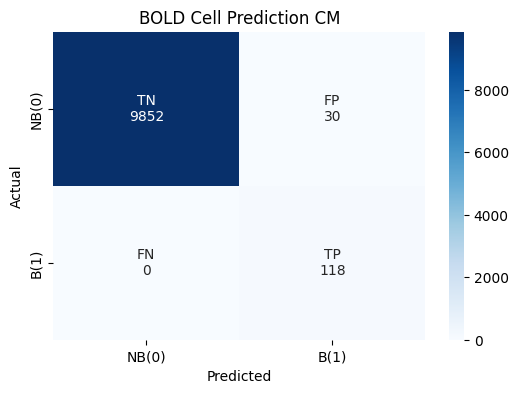


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(32,0): 0.914731 | (0,0): 0.915296 | (31,0): 0.915664 | (32,1): 0.916347 | (20,0): 0.916462 | (19,0): 0.916718 | (0,1): 0.916870 | (21,0): 0.917192 | (25,0): 0.917583 | (20,1): 0.917609 | (31,1): 0.917625 | (30,0): 0.917644 | (25,1): 0.917698 | (6,7): 0.917787 | (6,8): 0.917867 | (6,12): 0.917886 | (21,1): 0.917902 | (6,13): 0.917956 | (26,1): 0.917959 | (6,9): 0.918127 | (24,0): 0.918177 | (6,6): 0.918286 | (22,0): 0.918294 | (12,0): 0.918320 | (19,1): 0.918346 | (6,11): 0.918401 | (6,10): 0.918483 | (18,0): 0.918485 | (26,0): 0.918520 | (13,0): 0.918645 | (0,12): 0.918657 | (0,2): 0.918705 | (24,1): 0.918812 | (13,1): 0.918842 | (11,0): 0.918855 | (23,0): 0.918860 | (22,1): 0.918919 | (27,1): 0.918944 | (0,13): 0.918961 | (6,14): 0.918980 | (9,0): 0.919087 | (10,0): 0.919097 | (0,11): 0.919148 | (29,0): 0.919225 | (30,1): 0.919242 | (0,9): 0.919250 | (8,0): 0.919284 | (0,10): 0.

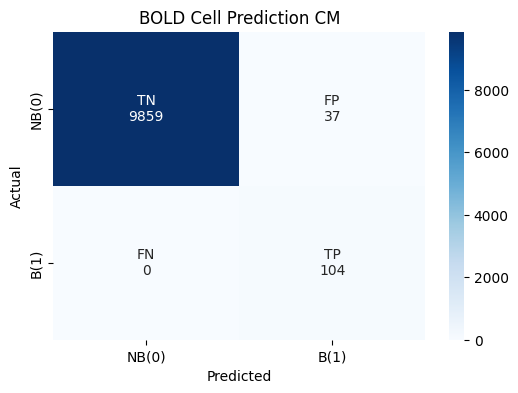


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,19): 0.067675 | (5,18): 0.069453 | (5,4): 0.401636 | (5,5): 0.461594 | (5,3): 0.757652 | (5,2): 0.818640 | (5,15): 0.902138 | (5,14): 0.910945 | (38,0): 0.911531 | (38,1): 0.912181 | (37,0): 0.912231 | (37,1): 0.913101 | (36,0): 0.914343 | (32,0): 0.914762 | (5,17): 0.914884 | (36,1): 0.914948 | (5,16): 0.915132 | (33,0): 0.915242 | (0,0): 0.915256 | (5,9): 0.915401 | (31,0): 0.915688 | (5,8): 0.915702 | (35,0): 0.915785 | (34,0): 0.915877 | (35,1): 0.916105 | (33,1): 0.916124 | (34,1): 0.916230 | (32,1): 0.916408 | (20,0): 0.916444 | (0,20): 0.916455 | (19,0): 0.916691 | (0,19): 0.916705 | (0,1): 0.916826 | (21,0): 0.917182 | (0,21): 0.917187 | (5,6): 0.917335 | (25,0): 0.917542 | (20,1): 0.917590 | (25,1): 0.917674 | (31,1): 0.917675 | (30,0): 0.917702 | (6,7): 0.917771 | (6,19): 0.917815 | (6,12): 0.917843 | (6,8): 0.917865 | (21,1): 0.917890 | (6,13): 0.917927 | (26

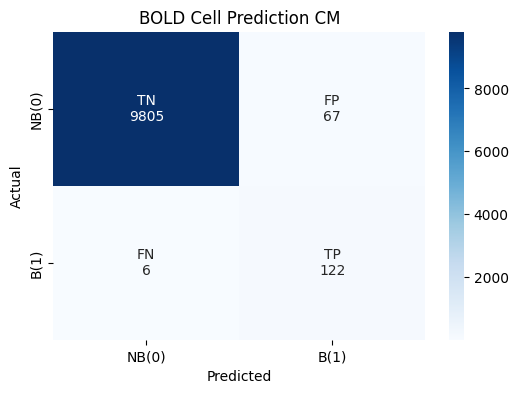


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)

## All Examples

Batch Inference: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396198:3802 | Actual = 396714:3286
Accuracy: 99.89% | Precision: 89.72% | Recall: 100.00% | F1-Score: 0.94



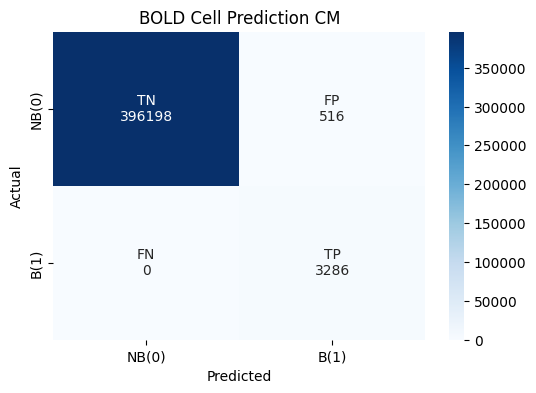

In [11]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49538:462 | Actual = 49602:398
Accuracy: 99.87% | Precision: 86.15% | Recall: 100.00% | F1-Score: 0.93



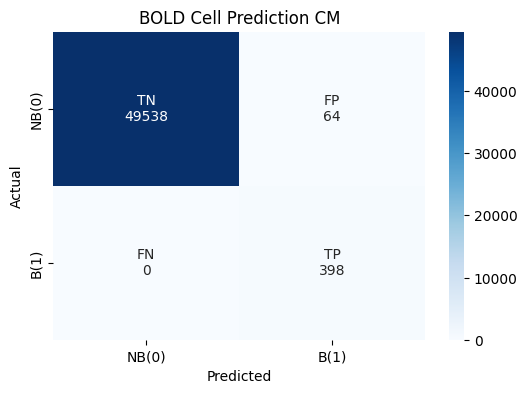

In [12]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49526:474 | Actual = 49606:394
Accuracy: 99.82% | Precision: 81.86% | Recall: 98.48% | F1-Score: 0.89



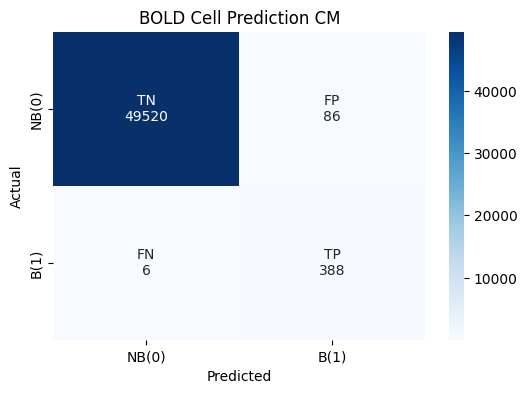

In [13]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)